In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.distributed import *

In [2]:
def preprocess(fname, type_index=None):
    t  = pd.read_csv(fname)
    s  = pd.read_csv('structures.csv')
    
    has_y = 'scalar_coupling_constant' in t.columns

    if has_y:
        # atom-atom level
        # molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
        scalar_couplings = pd.read_csv('scalar_coupling_contributions.csv') # fc,sd,pso,dso

        # atom level
        # molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
        magnetic_shielding = pd.read_csv('magnetic_shielding_tensors.csv')
        # molecule_name,atom_index,mulliken_charge
        mulliken_charges = pd.read_csv('mulliken_charges.csv')

        # molecule level
        # molecule_name,X,Y,Z
        dipole_moments = pd.read_csv('dipole_moments.csv')
        # molecule_name,potential_energy
        potential_energy = pd.read_csv('potential_energy.csv')

    t['molecule_index'] = pd.factorize(t['molecule_name'])[0] + t['id'].min()
    # make sure we use the same indexes in train/test (test needs to provide type_index)
    if type_index is not None:
        t['type_index'] = pd.factorize(pd.concat([pd.Series(type_index),t['type']]))[0][len(type_index):]
    else:
        t['type_index'] = pd.factorize(t['type'])[0]
    s = pd.concat([s,pd.get_dummies(s['atom'])], axis=1)

    max_items = 785836 if has_y else 422550
    max_atoms = int(s.atom_index.max() + 1)

    if has_y:
        contributions = ['fc','sd','pso','dso']
        magnetic_tensors = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
        XYZ = ['X','Y','Z']
    xyz = ['x', 'y', 'z']
    a_hot = ['C','F','H','N','O']
    
    x_xyz   = np.zeros((max_items,len(xyz),  max_atoms), dtype=np.float32)
    x_a_hot = np.zeros((max_items,len(a_hot),max_atoms), dtype=np.float32)
    x_type  = np.zeros((max_items,1,         max_atoms), dtype=np.float32)

    if has_y:
        y_scalar   = np.zeros((max_items,len(contributions)   ,max_atoms), dtype=np.float32)
        y_magnetic = np.zeros((max_items,len(magnetic_tensors),max_atoms), dtype=np.float32)
        y_mulliken = np.zeros((max_items,1                    ,max_atoms), dtype=np.float32)

        y_dipole   = np.zeros((max_items,len(XYZ)), dtype=np.float32)
        y_potential= np.zeros((max_items,1              ), dtype=np.float32)

        y_magnetic[...] = np.nan
        y_mulliken[...] = np.nan
    else:
        xt_ids = np.zeros((max_items, max_atoms), dtype=np.int32)


    m = np.zeros((max_items,), dtype=np.int32)
    i = j = 0
    
    for (m_name, m_index) ,m_group in tqdm(t.groupby(['molecule_name', 'molecule_index'])):
        ss = s[s.molecule_name==m_name]
        n_atoms = len(ss)
        if has_y:
            magnetic = magnetic_shielding[
                    (magnetic_shielding['molecule_name']==m_name)][magnetic_tensors].values.T

            mulliken = mulliken_charges[
                    (mulliken_charges['molecule_name']==m_name)]['mulliken_charge'].values.T

            scs = scalar_couplings[scalar_couplings['molecule_name']==m_name]
            
            y_dipole[j,:]= dipole_moments[dipole_moments['molecule_name']==m_name][XYZ].values
            y_potential[j,:]=potential_energy[
                potential_energy['molecule_name']==m_name]['potential_energy'].values
        
        for a_name,a_group in m_group.groupby('atom_index_0'):
            
            ref_a = ss[ss['atom_index']==a_name]
            
            x_xyz[i] = 0.
            x_a_hot[i] = ref_a[a_hot].values.T
            x_type[i] = -1

            x_xyz[i,:,:n_atoms] = (ss[xyz].values-ref_a[xyz].values).T  # xyz 
            x_a_hot[i,:,:n_atoms] = ss[a_hot].T                  # a_hot
            x_type[i,0,a_group['atom_index_1']] = a_group['type_index']  # type 
            
            if has_y:
                y_scalar[i,:,a_group['atom_index_1']] = scs[scs['atom_index_0']==a_name][contributions]
                y_magnetic[i,:,:n_atoms] = magnetic
                y_mulliken[i,:,:n_atoms] = mulliken
            else:
                xt_ids[i,a_group['atom_index_1']] = a_group['id']  

            m[i] = m_index
            i+=1
        j += 1
    assert i == max_items
    print(i,max_items)
    if has_y:
        return x_xyz,x_a_hot,x_type, m , y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential
    else:
        return x_xyz,x_a_hot,x_type, m, xt_ids

In [3]:
train_fname = Path('train.npz')
try:
    npzfile = np.load(train_fname)
    x_xyz = npzfile['x_xyz']
    x_a_hot = npzfile['x_a_hot']
    x_type = npzfile['x_type']
    y_scalar = npzfile['y_scalar']
    y_magnetic = npzfile['y_magnetic']
    y_mulliken = npzfile['y_mulliken']
    y_dipole = npzfile['y_dipole']
    y_potential = npzfile['y_potential']
    m = npzfile['m']
    max_items, max_atoms = x_xyz.shape[0], x_xyz.shape[-1]
except:
    x_xyz,x_a_hot,x_type, m , y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential = \
        preprocess(train_fname.with_suffix('.csv'))
    np.savez(train_fname, 
             x_xyz=x_xyz,
             x_a_hot=x_a_hot,
             x_type=x_type,
             y_scalar=y_scalar,
             y_magnetic=y_magnetic,
             y_mulliken=y_mulliken,
             y_dipole=y_dipole,
             y_potential=y_potential,
             m=m)
n_types = int(x_type[~np.isnan(x_type)].max() + 1)

In [4]:
test_fname = Path('test.npz')
try:
    npzfile = np.load(test_fname)
    xt_xyz = npzfile['x_xyz']
    xt_a_hot = npzfile['x_a_hot']
    xt_type = npzfile['x_type']
    mt = npzfile['m']
    xt_ids = npzfile['x_ids']
except:
    train_csv = pd.read_csv(train_fname.with_suffix('.csv'))
    xt_xyz,xt_a_hot,xt_type,mt,xt_ids = \
        preprocess(test_fname.with_suffix('.csv'), type_index = pd.factorize(train_csv['type'])[1])
    np.savez(test_fname, 
             x_xyz=xt_xyz,
             x_a_hot=xt_a_hot,
             x_type=xt_type,
             m=mt,
             x_ids=xt_ids)

In [5]:
[v.shape for v in [x_xyz,x_a_hot,x_type, y_scalar, y_magnetic, y_mulliken, y_dipole, y_potential, m]]

[(785836, 3, 29),
 (785836, 5, 29),
 (785836, 1, 29),
 (785836, 4, 29),
 (785836, 9, 29),
 (785836, 1, 29),
 (785836, 3),
 (785836, 1),
 (785836,)]

In [6]:
# TODO: Do norm in FASTAI instead of here
# TOCHECK: Filter only valid atoms (otherwise repeated atoms may skew stats)
#xyz_mean, xyz_std = x_xyz.mean(axis=(0,2), keepdims=True),  x_xyz.std(axis=(0,2), keepdims=True)
#x_xyz  = (x_xyz  - xyz_mean) / xyz_std
#xt_xyz = (xt_xyz - xyz_mean) / xyz_std

In [7]:
[v.shape for v in [xt_xyz,xt_a_hot,xt_type, mt]]

[(422550, 3, 29), (422550, 5, 29), (422550, 1, 29), (422550,)]

In [8]:
dropout_rate = 0.1
# from https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        #iden = torch.eye(self.k, dtype=x.dtype, device=x.device).view(1,self.k*self.k).expand((batchsize,-1))
        #x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, input_transform = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STNkd(k=3) if input_transform else None
        self.conv1 = torch.nn.Conv1d(9, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        if self.stn is not None:
            x_xyz = x[:,:3,...].clone()
            trans = self.stn(x_xyz)
            x[:,:3,:] = torch.bmm(trans, x_xyz)
        else:
            trans = torch.eye(
                self.k, dtype=x.dtype, device=x.device).view(1,self.k*self.k).expand((batchsize,-1))
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).expand(-1, -1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat
    
class PointNetDenseReg(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseReg, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.dropout(x,p=dropout_rate)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        #x = x.transpose(2,1).contiguous()
        #x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat if self.feature_transform else trans

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d, dtype=trans.dtype, device=trans.device).unsqueeze(0)
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

In [9]:
class MoleculeItem(ItemBase):
    def __init__(self,i,xyz,a_hot,type): 
        self.i, self.xyz,self.a_ahot,self.type = i,xyz,a_hot,type
        self.data = torch.cat([Tensor(xyz), Tensor(self.a_ahot),Tensor(self.type)], dim=0)
    def __str__(self):
        # TODO: count n_atoms correctly. 
        n_atoms = np.count_nonzero(np.sum(np.absolute(self.xyz), axis=0))+1
        n_couplings = np.sum((self.type!=-1))
        return f'{self.i} {n_atoms} atoms {n_couplings} couplings'
    
class ScalarCouplingItem(ItemBase):
    def __init__(self,scalar,magnetic,mulliken,dipole,potential,**kwargs): 
        self.scalar,self.magnetic,self.mulliken,self.dipole,self.potential = \
            scalar,magnetic,mulliken,dipole,potential
        self.data = Tensor(np.sum(scalar, axis=0))
    def __str__(self):
        res, spacer, n_couplings = '', '', 0
        for s in self.data:
            if s==0.: spacer = ' * '
            else: 
                res += f'{spacer}{s:.4f}'
                spacer = ' '
                n_couplings +=1
        return f'{n_couplings}: {res}'
    def __hash__(self): return hash(str(self))

In [10]:
def LMAEMaskedLoss(input_outputs,target,feature_transform_regularizer_weight=0.1):
    input, output, trans, trans_feat = input_outputs
    loss = 0.
    n = 0
    for type in range(n_types):
        mask = (input[:,8,:] == type)
        if mask.sum() > 0:
            _output,_target = output[:,0,:], target
            loss += torch.log((_output[mask] - _target[mask]).abs().mean()+1e-9)
            n+=1
    return loss/n + feature_transform_regularizer(trans)*feature_transform_regularizer_weight

In [11]:
class ScalarCouplingList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.c = 1
        self.loss_func = LMAEMaskedLoss

    def get(self, i):
        o = super().get(i)
        return ScalarCouplingItem(*o)

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

In [12]:
data = ItemList(items=(MoleculeItem(i,*v) for i,v in enumerate(zip(x_xyz,x_a_hot,x_type))),
                label_cls=ScalarCouplingItem)

In [13]:
from sklearn.model_selection import train_test_split
_, idx_valid_split = train_test_split(range(m.max()+1), test_size=0.1, random_state=13)
idx_valid_split = np.argwhere(np.isin(m, idx_valid_split)).flatten()

In [14]:
data = data.split_by_idx(idx_valid_split)
data

ItemLists;

Train: ItemList (707619 items)
0 5 atoms 4 couplings,1 5 atoms 3 couplings,2 5 atoms 2 couplings,3 5 atoms 1 couplings,4 4 atoms 3 couplings
Path: .;

Valid: ItemList (78217 items)
9 8 atoms 7 couplings,10 8 atoms 6 couplings,11 8 atoms 5 couplings,12 8 atoms 4 couplings,13 8 atoms 3 couplings
Path: .;

Test: None

In [15]:
data = data.label_from_func(
    func=lambda o: (y_scalar[o.i], y_magnetic[o.i], y_mulliken[o.i], y_dipole[o.i], y_potential[o.i]),
    label_cls=ScalarCouplingList)

In [16]:
data=data.databunch()

In [17]:
class ChemCallback(Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_begin(self,**kwargs):
        pass # PAVEL -> at some point do learner.opt.clear() or equivalent reset opt internals 
    def on_batch_begin(self,**kwargs):
        "Save the last_input (i.e. current input) for on_loss_begin_callback"
        self.last_input = kwargs['last_input']
    def on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
        "Add last_input to last_output, i.e. input to loss function b/c we need it"
        return {'last_output': (self.last_input, *last_output)}

In [18]:
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()
net = PointNetDenseReg(k = 1)
learner = Learner(data,net, callbacks=[ChemCallback()], 
                  loss_func=partial(LMAEMaskedLoss,feature_transform_regularizer_weight=0.),
                  metrics=[partial(LMAEMaskedLoss,feature_transform_regularizer_weight=0.)])

In [19]:
learner = learner.to_parallel()#.to_fp16() # to_parallel/fp_16 does not converge as well. why?
data.batch_size = 4096*2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02


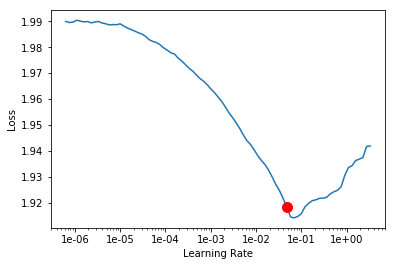

In [20]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [21]:
learner.fit_one_cycle(1000, max_lr=5e-2)
#learner.fit(20, lr=1e-3)

epoch,train_loss,valid_loss,LMAEMaskedLoss,time
0,1.602141,1.563128,1.563128,00:29
1,1.129877,1.028806,1.028806,00:29
2,0.805494,0.764253,0.764253,00:29
3,0.581024,0.473472,0.473472,00:29
4,0.310591,0.154733,0.154733,00:29
5,0.134316,0.067325,0.067325,00:29
6,0.025923,-0.039124,-0.039124,00:29
7,-0.049107,-0.083051,-0.083051,00:29
8,-0.105845,-0.073671,-0.073671,00:29
9,-0.156511,-0.180267,-0.180267,00:29


In [22]:
data.add_test(ItemList(items=(MoleculeItem(i,*v) for i,v in enumerate(zip(xt_xyz,xt_a_hot,xt_type)))))